In [5]:
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from pprint import pprint

import spacy

import pickle
import re
import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.gensim

import matplotlib.pyplot as plt
import pandas as pd

import nltk
import os

from tqdm import tqdm
import numpy as np

In [6]:
CLEAN_TWEETS_PATH_CSV = os.path.join("..", "result", "clean_tweet.csv")
RESULT_PATH = [os.path.join("..", "result", "clean_tweet_topics.csv"), os.path.join("content", "clean_tweet_topics.csv"),\
              os.path.join("..", "Tache4_barre de recherche", "content", "clean_tweet_topics.csv")]

In [18]:
tweets_df = pd.read_csv(CLEAN_TWEETS_PATH_CSV)[['id', 'text']]

# Tokenize the tweets using NLTK
tokenizer = nltk.tokenize.TweetTokenizer()
tweets = [tokenizer.tokenize(tweet) for tweet in tweets_df['text'].tolist()]

In [19]:
tweets_df

,id,text
0,98454970654916608,republican democrat create economic problem
1,1234653427789070336,thrill back great city charlotte north carolin...
2,1218010753434820614,cbsherridge read letter surveillance court obt...
3,1304875170860015617,the unsolicited mail ballot scam major threat ...
4,1218159531554897920,mzhemingway very friendly tell event comey app...
...,...,...
55237,1319485303363571714,randpaul know joebiden think continue lie want...
55238,1319484210101379072,elisestefanik president realdonaldtrump excels...
55239,1319444420861829121,teamtrump live presidential debate debate text...
55240,1319384118849949702,just sign order support worker delphi corporat...


In [20]:
id2word = Dictionary(tweets)
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in tweets]
#print(corpus[:1])


In [50]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word,alpha="auto", random_state=100, passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [51]:
limit=40; start=2; step=1;

In [52]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=tweets, start=start, limit=limit, step=step)


100%|██████████| 38/38 [37:35<00:00, 59.37s/it]


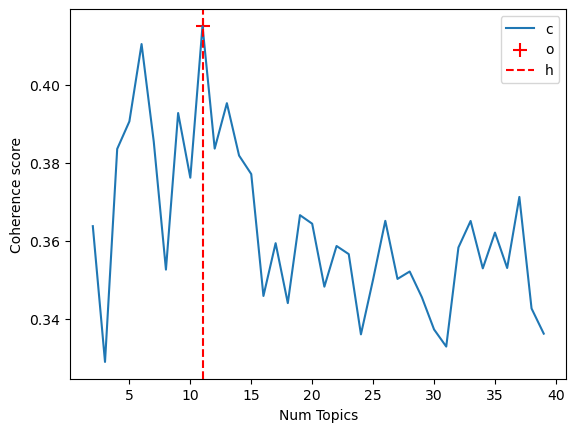

In [75]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.scatter(coherence_values.index(max(coherence_values))+2, coherence_values[coherence_values.index(max(coherence_values))], marker="+", color="r", s=100)
plt.axvline(x=coherence_values.index(max(coherence_values))+2, color='red', linestyle='--')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.savefig(os.path.join("content", "coherence_values_lda.png"))
plt.show()

In [54]:
best_result_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[best_result_index]
# Select the model and print the topics
model_topics = optimal_model.show_topics(formatted=False)
print(f'''The {x[best_result_index]} topics gives the highest coherence score 
of {coherence_values[best_result_index]}''')

The 11 topics gives the highest coherence score 
of 0.41501177695990976


In [58]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
pyLDAvis.save_html(p, os.path.join("content","cartographie_thematique.html"))
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.367715  0.014370       1        1  45.673443
3      0.081882 -0.417555       2        1  11.779788
7      0.097307  0.126562       3        1   9.307172
9      0.200781  0.154745       4        1   9.091998
1     -0.079524 -0.020954       5        1   4.889509
8     -0.084207  0.015517       6        1   4.060447
10    -0.109265  0.020645       7        1   3.739904
4     -0.125235  0.024427       8        1   3.052303
5     -0.114525  0.023187       9        1   2.978929
6     -0.109938  0.034097      10        1   2.750368
0     -0.124991  0.024960      11        1   2.676140, topic_info=                 Term          Freq         Total Category  logprob  loglift
25                  r  16775.000000  16775.000000  Default  30.0000  30.0000
43                 rt  12540.000000  12540.000000  Default  29.0000  29.0000
94    realdonaldtrump   8077.000000   8077.000000  Default  28.0000  28.0000
141             trump   7295.000000   7295.000000  Default  27.0000  27.0000
91          president   6249.000000   6249.000000  Default  26.0000  26.0000
...               ...           ...           ...      ...      ...      ...
5273             leak    169.343078    170.131630  Topic11  -4.7344   3.6161
3040            exist    164.059206    164.847796  Topic11  -4.7661   3.6160
5442            hater    159.877151    160.665669  Topic11  -4.7919   3.6159
122           scandal    159.689570    160.478096  Topic11  -4.7931   3.6159
984        corruption    158.977919    159.766464  Topic11  -4.7976   3.6158

[399 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
127       1  0.994803      a
127       2  0.001594      a
127       4  0.003188      a
1500      8  0.995803    abc
647       6  0.996637  abuse
...     ...       ...    ...
399       1  0.999729  would
1702     11  0.997029  write
472       1  0.991650   year
472       3  0.007884   year
1858      3  0.999319   york

[409 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 8, 10, 2, 9, 11, 5, 6, 7, 1])

# Save the model

In [66]:
from gensim.test.utils import datapath
optimal_model.save(os.path.join("content", "Model", "LDA_tweets_topic.model"))

# Label the corpus 

In [21]:
optimal_model = LdaModel.load(os.path.join("content", "Model", "LDA_tweets_topic.model"))

In [22]:
tweets_df['topics'] = [[top[1] for top in tops] for tops in optimal_model.get_document_topics(corpus, minimum_probability=0)]

In [34]:
tweets_df.head()

,id,text,topics
0,98454970654916608,republican democrat create economic problem,"[0.020979358, 0.03856975, 0.41228178, 0.141269..."
1,1234653427789070336,thrill back great city charlotte north carolin...,"[0.010785601, 0.23879117, 0.4440115, 0.0961788..."
2,1218010753434820614,cbsherridge read letter surveillance court obt...,"[0.01710649, 0.03198686, 0.394938, 0.15369062,..."
3,1304875170860015617,the unsolicited mail ballot scam major threat ...,"[0.029374106, 0.057501942, 0.38067678, 0.10244..."
4,1218159531554897920,mzhemingway very friendly tell event comey app...,"[0.053457394, 0.030274658, 0.41499487, 0.07379..."


# Save the tweet with there topics

In [15]:
for path in RESULT_PATH:
    tweets_df.to_csv(path, index=False)

In [70]:
tweets_df.head()

,id,text,topics
0,98454970654916608,republican democrat create economic problem,"[0.020979358, 0.03856975, 0.41228178, 0.141269..."
1,1234653427789070336,i thrill back great city charlotte north caro...,"[0.010285988, 0.23111925, 0.44282803, 0.115309..."
2,1218010753434820614,rt cbsherridge read letter surveillance cou...,"[0.016445538, 0.030235216, 0.38019374, 0.14777..."
3,1304875170860015617,the unsolicited mail in ballot scam major thre...,"[0.028947629, 0.05664425, 0.4161862, 0.0401720..."
4,1218159531554897920,rt mzhemingway very friendly tell event come...,"[0.04952861, 0.028055018, 0.45302987, 0.137099..."
